In [199]:
import pandas as pd
import numpy as np
from scipy import signal, stats

In [2]:
df = pd.read_excel('DEMO_DEATH_OPEN.xlsx')

In [3]:
covid = pd.read_excel("COVID19BE.xlsx", sheet_name="MORT")

In [4]:
ts = df.groupby('DT_DATE')['MS_NUM_DEATH'].sum().to_frame()
ts = ts.resample("1D").fillna(0)

In [5]:
ts2 = covid.groupby("DATE")["DEATHS"].sum().to_frame()
ts2 = ts2.reindex(ts.index).fillna(0).astype(int)

In [6]:
data = ts.merge(ts2, left_index=True, right_index=True, how="left")
data.columns = ["total", "covid"]
data.index.name = "date"
data["ratio"] = data["covid"]/data["total"]
data["neto"] = data["total"] - data["covid"]
data

,total,covid,ratio,neto
date,,,,
2009-01-01,310,0,0.000000,310
2009-01-02,322,0,0.000000,322
2009-01-03,310,0,0.000000,310
2009-01-04,344,0,0.000000,344
2009-01-05,366,0,0.000000,366
...,...,...,...,...
2022-02-23,305,19,0.062295,286
2022-02-24,335,21,0.062687,314
2022-02-25,318,28,0.088050,290


In [24]:
data.max()

total                     675
covid                     324
ratio                 0.50546
neto                      478
yearly    1904-12-31 00:00:00
year                     2022
dtype: object

<AxesSubplot:xlabel='date'>

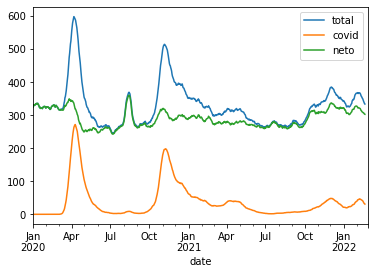

In [93]:
smooth = data[["total", "covid", "neto"]].rolling(14).mean().shift(-7)
smooth.loc["2020":,:].plot()

In [94]:
data["yearly"] = data.index.map(lambda t: t.replace(year=1904))
data["year"] = data.index.year

In [95]:
smooth["yearly"] = smooth.index.map(lambda t: t.replace(year=1904))
smooth["year"] = smooth.index.year

In [176]:
c = data.loc["2010":"2022",:].pivot_table(index="yearly", columns="year", values=["total", "covid", "neto"])
c

covid                                               ...  total  \
year        2010 2011 2012 2013 2014 2015 2016 2017 2018 2019  ...   2013   
yearly                                                         ...          
1904-01-01   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  323.0   
1904-01-02   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  338.0   
1904-01-03   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  325.0   
1904-01-04   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  309.0   
1904-01-05   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  313.0   
...          ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...    ...   
1904-12-27   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  300.0   
1904-12-28   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  322.0   
1904-12-29   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  303.0   
1904-12-30   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  288.0   
1904-12-31   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  339.0   

                                                                           
year         2014   2015   2016   2017   2018   2019   2020   2021   2022  
yearly                                                                     
1904-01-01  333.0  356.0  287.0  351.0  317.0  326.0  325.0  342.0  333.0  
1904-01-02  317.0  383.0  300.0  361.0  357.0  355.0  325.0  310.0  300.0  
1904-01-03  344.0  366.0  288.0  338.0  359.0  355.0  351.0  321.0  355.0  
1904-01-04  297.0  330.0  338.0  360.0  363.0  356.0  322.0  340.0  332.0  
1904-01-05  296.0  331.0  318.0  378.0  374.0  323.0  298.0  362.0  331.0  
...           ...    ...    ...    ...    ...    ...    ...    ...    ...  
1904-12-27  315.0  295.0  340.0  331.0  325.0  345.0  350.0  352.0    NaN  
1904-12-28  325.0  293.0  326.0  350.0  335.0  283.0  385.0  367.0    NaN  
1904-12-29  341.0  316.0  375.0  343.0  380.0  306.0  381.0  339.0    NaN  
1904-12-30  341.0  314.0  369.0  320.0  321.0  311.0  337.0  393.0    NaN  
1904-12-31  344.0  325.0  341.0  313.0  304.0  302.0  369.0  364.0    NaN  

[366 rows x 39 columns]

In [173]:
x = data.pivot_table(index="yearly", columns="year", values="neto").median(axis=1).to_frame(name="profile")
x["savgol"] = signal.savgol_filter(x["profile"], 61, 7, mode="wrap")

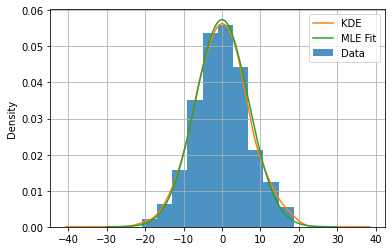

In [205]:
error = (x["profile"] - x["savgol"])
params = stats.norm.fit(error)
X = stats.norm(*params)
Xlin = np.linspace(-30, 30, 200)
axe = error.plot(kind="hist", density=1, alpha=0.8)
error.plot(kind="kde")
axe.plot(Xlin, X.pdf(Xlin))
axe.legend(["KDE", "MLE Fit", "Data"])
axe.grid()

In [206]:
params

(4.847642907428257e-06, 6.949078621018105)

In [204]:
stats.ks_1samp(error, X.cdf)

KstestResult(statistic=0.02061268023874796, pvalue=0.9969187015729608)

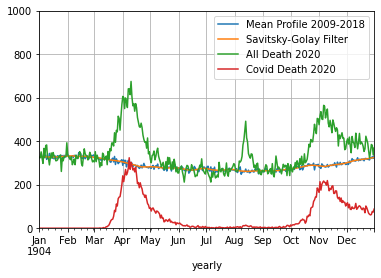

In [193]:
axe = x.plot()
c["total"][2020].plot(ax=axe)
c["covid"][2020].plot(ax=axe)
axe.legend(["Mean Profile 2009-2018", "Savitsky-Golay Filter", "All Death 2020", "Covid Death 2020"])
axe.set_ylim([0, 1000])
axe.grid()

In [ ]:
axe = smooth.loc["2009":"2018",:].pivot_table(index="yearly", columns="year", values="neto").median(axis=1).plot()
axe.set_ylim([0, 800])

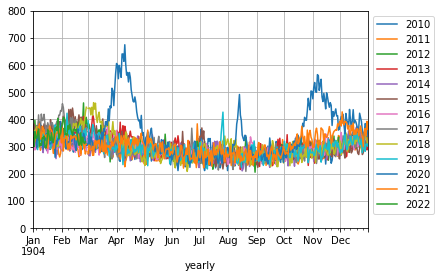

In [210]:
axe = data.loc["2010":"2022",:].pivot_table(index="yearly", columns="year", values="total").plot()
axe.set_ylim([0, 800])
axe.legend(bbox_to_anchor=(1,1))
axe.grid()

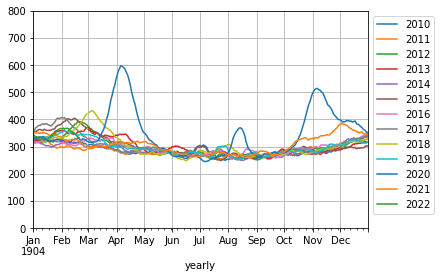

In [98]:
axe = smooth.loc["2010":"2022",:].pivot_table(index="yearly", columns="year", values="total").plot()
axe.set_ylim([0, 800])
axe.legend(bbox_to_anchor=(1,1))
axe.grid()

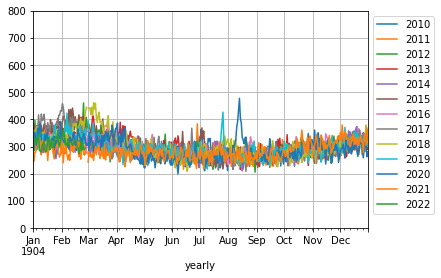

In [99]:
axe = data.loc["2010":"2022",:].pivot_table(index="yearly", columns="year", values="neto").plot()
axe.set_ylim([0, 800])
axe.legend(bbox_to_anchor=(1,1))
axe.grid()

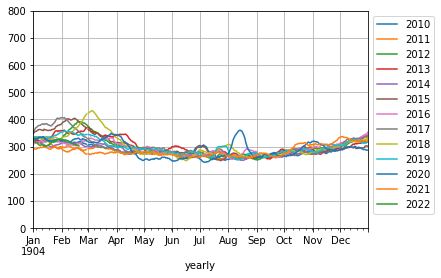

In [100]:
axe = smooth.loc["2010":"2022",:].pivot_table(index="yearly", columns="year", values="neto").plot()
axe.set_ylim([0, 800])
axe.legend(bbox_to_anchor=(1,1))
axe.grid()